# Plot the Beaching Aggregated Fields using Bootstrap Significance

This sheet is for all beaching types

In [2]:
import cmocean.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 16, 'axes.titlesize': 'medium'})

In [4]:
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]
divarea = 1/(mesh.e1t[0, 1:-1, 1:-1] * mesh.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh.e1t[0, 1:-1:, 1:-1], mesh.e2t[0, 1:-1, 1:-1])
mesh.close()

In [5]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)

## Beaching

### Beaching Presence: Set-up and Preparation

In [8]:
def get_dataframe(oil_type):
    thefile =f'/scratch/allen/MIDOSS/aggregate/fiftieth_200_{oil_type}.nc'
    oil = xr.open_dataset(thefile)
    whichspills = "All Oil Spills"
    smalloils = 113 + 54
    
    ma_beaching_pres = np.ma.masked_array(oil.beachpresence, oil.beachpresence == 0)
    
    coords=np.asarray(np.argwhere(ma_beaching_pres))
    x, y = coords[:, 0], coords[:, 1]

    df = pd.DataFrame(data={'x': x,
                       'y': y,
                       'z': ma_beaching_pres.compressed()})

    df.sort_values('z', ascending=True, inplace=True)
    return df

In [9]:
title = {'diesel': 'Diesel',
        'bunker': 'Bunker-C',
        'akns': 'ANS'}

### Beaching Presence: Plot

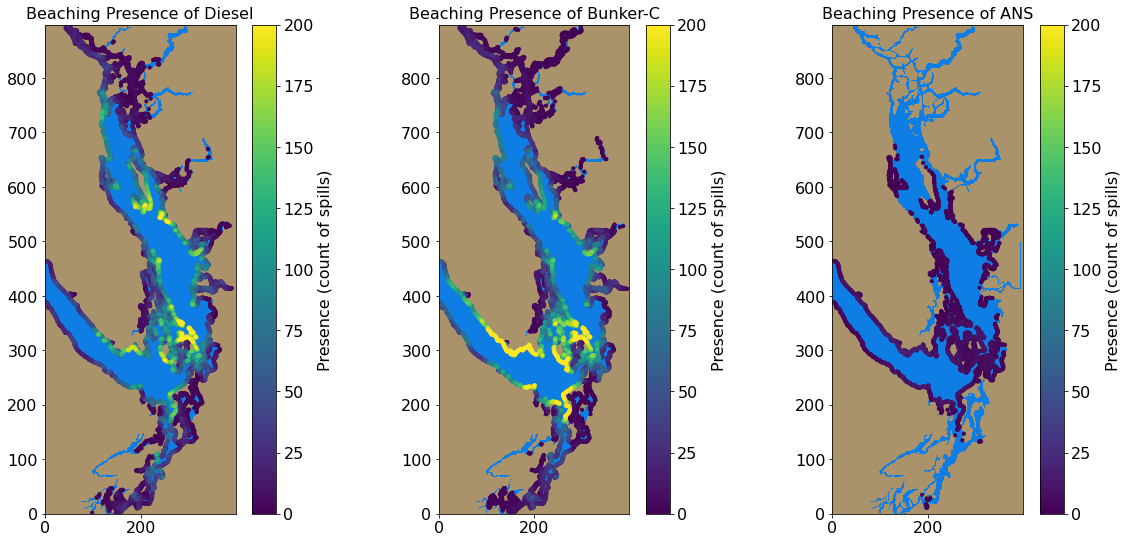

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(20, 9))

for ax, oil_type in zip(axs, ['diesel', 'bunker', 'akns']):
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)

    df = get_dataframe(oil_type)

    C = ax.scatter(df.y, df.x, c=df.z, s=10, norm=colors.Normalize(vmin=0, vmax=200))
    cb = fig.colorbar(C, ax=ax);    
    cb.set_label('Presence (count of spills)')
    ax.set_title(f'Beaching Presence of {title[oil_type]}');
fig.savefig('beachpresence_t3_h.png', dpi=450)

### Beaching Volume: Set-up and Preparation

In [44]:
# Good if good to 100% of beaching volume
perol = 0.5
absol = np.log(perol+1)
eps = 1e-7
mcsize = 49

bv_perol = perol

In [45]:
def get_dataframe_volume(oil_type):
    thefile =f'/scratch/allen/MIDOSS/aggregate/fiftieth_200_{oil_type}.nc'
    oil = xr.open_dataset(thefile)
    whichspills = "All Oil Spills"
    smalloils = 113 + 54
    
    ma_beach_oil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0)

    den = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
    beachoil_ste = np.std(oil.beaching_oil/(oil.beachpresence + eps), axis=0, ddof=1) / np.sqrt(den)
    beachedoil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), (oil.beachpresence <= 1) | (
        (beachoil_ste > absol) )) 
    
    beach_per_length = np.exp(beachedoil) * alength * 1000
    
    coords=np.asarray(np.argwhere(beachedoil))
    x, y = coords[:, 0], coords[:, 1]
    
    df = pd.DataFrame(data={'x': x,
                       'y': y,
                       'z': beach_per_length.compressed()})

    df.sort_values('z', ascending=True, inplace=True)
    return df

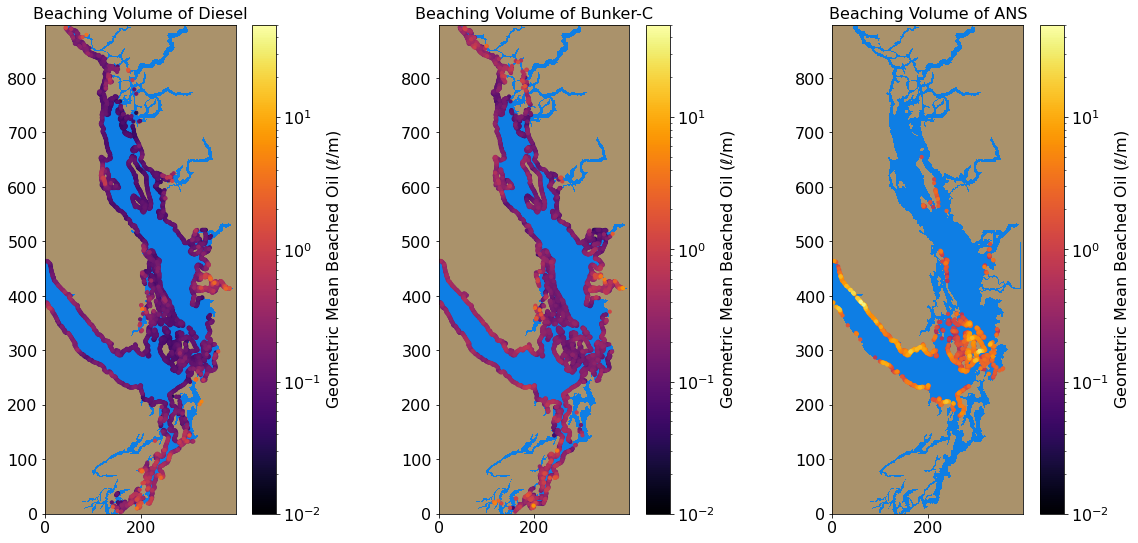

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(20, 9))

vmin, vmax = 0.01, 50

for ax, oil_type in zip(axs, ['diesel', 'bunker', 'akns']):
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    
    df = get_dataframe_volume(oil_type)
    
    
    
    C = ax.scatter(df.y, df.x, c=df.z, s=10, cmap='inferno', 
                   norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    
    cb = fig.colorbar(C, ax=ax);
    cb.set_label('Geometric Mean Beached Oil ($\ell$/m)')
    ax.set_title(f'Beaching Volume of {title[oil_type]}'); 
fig.savefig('beachvolume_t3_h.png', dpi=450)